In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

In [14]:
!python ./Scripts/universities_extraction.py
!python Scripts/parse_metadata.py 

[Info] Saved universities data to ../data/Universities.csv
[INFO] Got data from 874 files
[INFO] Saved to individual authors list: data/ as Parsed_metadata.csv


Loading the data about universities:

In [15]:
universities = pd.read_csv('data/Universities.csv', index_col=0)
universities.head()

,name,domain,mail,authorindex,file,country
0,University of Colorado at Boulder,colorado.edu,rebecca.swanson@colorado.edu,0,import2018_371,United States
1,University of Colorado at Boulder,colorado.edu,leighanna.hinojosa@colorado.edu,1,import2018_371,United States
2,University of Colorado at Boulder,colorado.edu,joseph.polman@colorado.edu,2,import2018_371,United States
3,Indiana University at Bloomington,indiana.edu,huang220@indiana.edu,0,import2018_417,United States
4,gmail,gmail.com,agomoll90@gmail.com,1,import2018_417,NaN


## Base analysis of Universities present in dataset

#### What universities has the most contributors, and what percentage do they make up:

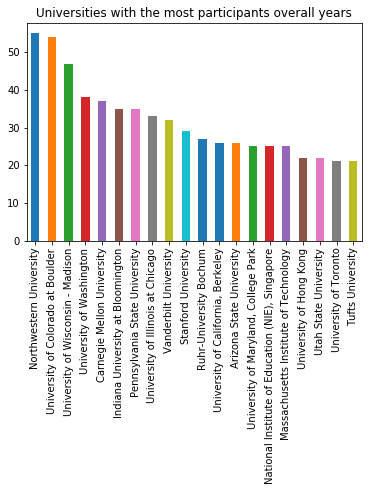

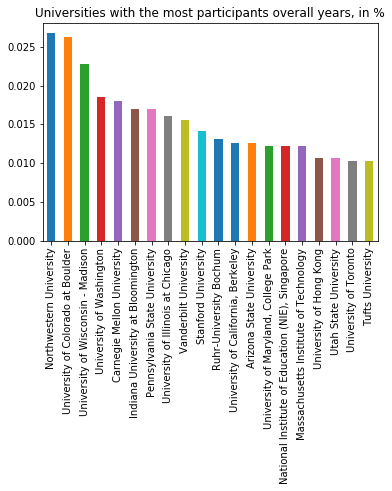

In [16]:
plt.title('Universities with the most participants overall years')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')
plt.show()
plt.title('Universities with the most participants overall years, in %')
(universities[(universities.name != 'gmail')& (~universities.mail.duplicated())].name.value_counts().head(20)/universities[(~universities.mail.duplicated())].shape[0]).plot(kind='bar')
plt.show()

#### What are the countries where the most contributors are?

As determined by university affiliation

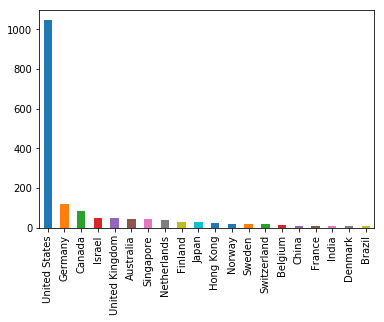

In [17]:
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.show()

## Considering ICLS and CSCL:

We look at which universities are present every year, only present during CSCL years and ICLS years:

In [18]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) ]

In [19]:
grouping =  pd.merge(metadata, universities, on='file')

In [20]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['name']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)

In [21]:
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [22]:
print('Number of universities represeted every year: ', len(all_years))
print('Number of universities represeted at every ICLS but not CSCL: ', len(ICLS))
print('Number of universities represeted at every CSCL but not ICLS: ', len(CSCL))

Number of universities represeted every year:  37
Number of universities represeted at every ICLS but not CSCL:  58
Number of universities represeted at every CSCL but not ICLS:  12


We now look into publication counts per university over the years:

In [23]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.name.isin(all_years))]

ranks = pd.DataFrame(grouping.groupby('issued').name.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)
ranks.head()

,issued,name,count
0,2015,University of Toronto,12
1,2015,Universität Duisburg-Essen,9
2,2015,EPFL - EPF Lausanne,8
3,2015,Indiana University at Bloomington,8
4,2015,Carnegie Mellon University,7


There seems to be some patter indicating that even amongst universities that participate every year, there is a fluctiation of numbr of papers between ICLS and CSCL

In [24]:
#we only look at universities that have at least two submissions  each year
all_ = set()
ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: all_.update(set(x['name'])))

for s in ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: set(x['name'])).tolist():
    all_ = all_.intersection(s)

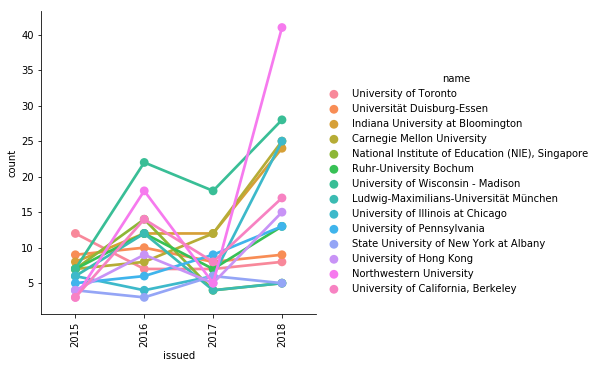

In [25]:
sns.catplot(data=ranks[ranks['name'].isin(all_) ], x='issued', y='count',kind='point', hue='name')
plt.xticks(rotation=90)
plt.show()

### Do the same thing with countries

We have an interessting result:

Increase in number of participants is mostly due to new participants from the us

In [26]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['country']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)

In [27]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.country.isin(all_years))]


ranks = pd.DataFrame(grouping.groupby('issued').country.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)

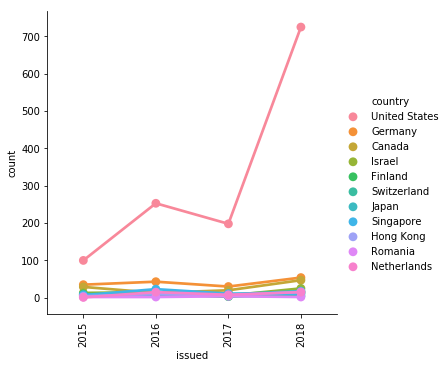

In [28]:
sns.catplot(data=ranks, x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

Looking at it without america:

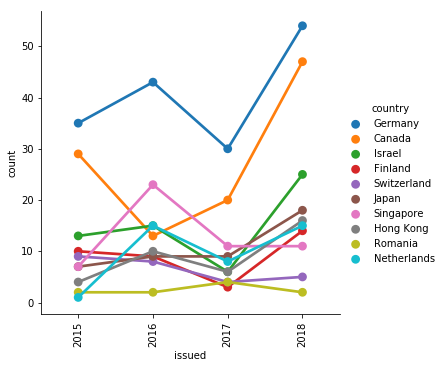

In [29]:
sns.catplot(data=ranks[(ranks.country != 'United States')], x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

We now take an alternative view at countries, to see evolution in percentage:

In [18]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated())]

In [19]:
viz = pd.DataFrame(grouping[['country', 'name', 'file', 'issued']].groupby(['issued', 'country']).name.value_counts())
viz.columns = ['counts']
viz.reset_index(inplace=True)

Set a colorbar to get more readable plot:

In [20]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()/viz.groupby(['issued']).counts.sum()*100).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
to_ignore = country_bar.loc[country_bar.counts < 1].country.unique()
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

country_bar.head()

,country,issued,counts
0,Australia,2015,3.787879
1,Australia,2016,3.070175
2,Australia,2017,1.807229
3,Australia,2018,1.819923
4,Canada,2015,10.984848


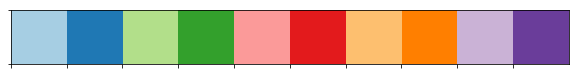

In [21]:
categories = country_bar.country.unique()
palette = sns.color_palette(palette='Paired', n_colors=len(categories)+1)

sns.palplot(palette)

We see that america makes up a bigger and bigger percentage

Text(0.5,1,'Participants by country (%)')

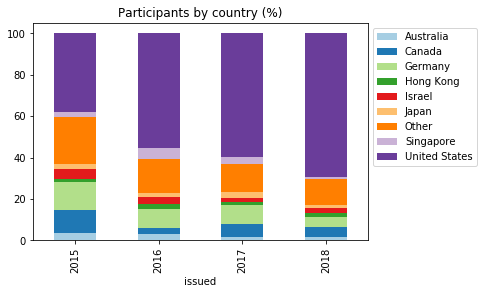

In [22]:
from matplotlib.colors import ListedColormap

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()

country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country (%)')

In terms of absolute attendance, countries with less than 4 participants in any year are grouped into other to improve visibility:

Text(0.5,1,'Participants by country by conference')

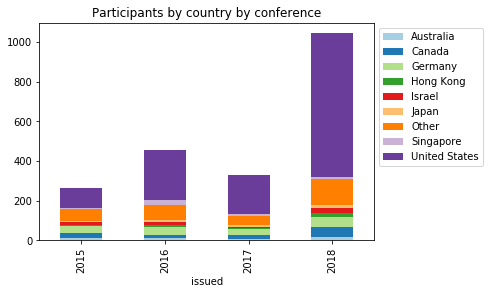

In [23]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

categories = country_bar.country.unique()
palette = sns.color_palette(palette='Paired', n_colors=len(categories)+1)

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()
country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

From before we know that some universities have very large increase, therefore we look at the increase in america more closely. We see that there are a lot more of authors from various universities contributing, which weren't contributing before.

Text(0.5,1,'Participants by US-university by conference')

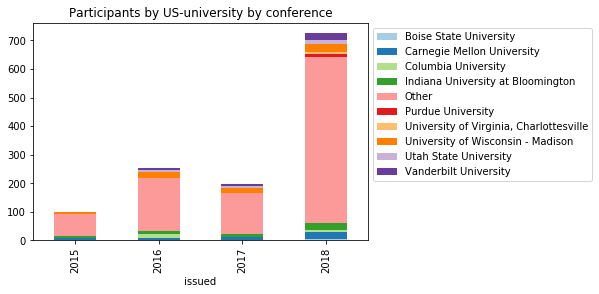

In [24]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

to_ignore = uni_bar.loc[uni_bar.counts < 6].name.unique()

uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by US-university by conference')

Text(0.5,1,'Participants by country by conference')

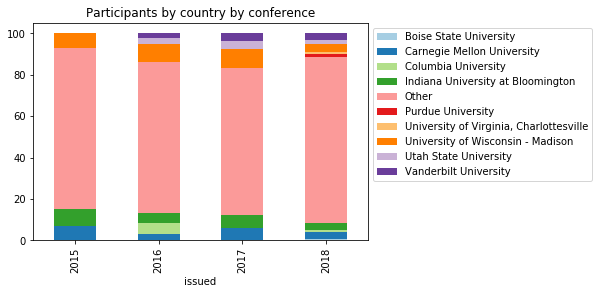

In [25]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()/uni_bar.groupby(['issued']).counts.sum()*100).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)
uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

# Looking at where people collaborate:

## Building a collaboration graph, only taking into consideration countries:

We use the author index to match up author names with indices:

In [26]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['authorindex']), axis=1)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

associations.sample(10)[['mail', 'long_name']]

,mail,long_name
2362,nadine.melzner@phil.uni-augsburg.de,"Melzner, Nadine"
1473,roshima@inf.shizuoka.ac.jp,"Oshima, Ritsuko"
1616,shermanm@mit.edu,"Sherman, Mark A"
3194,bmclaren@cs.cmu.edu,"McLaren, Bruce M."
180,roshima@inf.shizuoka.ac.jp,"Oshima, Ritsuko"
3066,sri@iitb.ac.in,"Iyer, Sridhar"
1410,Pierre.Tchounikine@imag.fr,"Tchounikine, Pierre"
1232,hotaywanying@gmail.com,"Tay, Wan Ying"
1342,duck@cs.colorado.edu,"Eisenberg, Michael"
2736,stevenallangray@gmail.com,"Gray, Steven"


In [27]:
pub_collab = associations[['file_x','country', 'name']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()
collabs.dropna(inplace=True)
collabs = collabs[collabs.country_x != collabs.country_y]
collabs.head()

,file_x,country_x,name_x,country_y,name_y
52,import2015short_1118,United States,University of Illinois at Chicago,Canada,University of Toronto
54,import2015short_1118,Canada,University of Toronto,United States,University of Illinois at Chicago
56,import2015short_1118,Canada,University of Toronto,United States,Indiana University at Bloomington
58,import2015short_1118,United States,Indiana University at Bloomington,Canada,University of Toronto
98,import2017_63,United States,New York University,Canada,Simon Fraser University


Building collaboration graph:

In [28]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes.head()

,index,country
0,0,United States
1,1,Canada
2,2,Belgium
3,3,Finland
4,4,United Kingdom


In [29]:
country_index = nodes.country.to_dict()
country_index = {v: k for k, v in country_index.items()}

collabs['index_x'] = collabs.country_x.map(country_index)
collabs['index_y'] = collabs.country_y.map(country_index)

edges = collabs[['index_x', 'index_y']].copy()

In [30]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    i, j = int(row.index_x), int(row.index_y)
    adjacency[i, j] += 1

In [31]:
adjacency

array([[ 0, 92,  9, ...,  0,  0,  2],
       [92,  0,  0, ...,  0,  0,  4],
       [ 9,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  4,  0, ...,  0,  0,  0]])

In [32]:
graph = nx.from_numpy_array(adjacency)

mapping = nodes.country.to_dict()

H=nx.relabel_nodes(graph,mapping)

nx.write_gexf(H, 'data/country_graph.gexf')

Most intercountry collaborations overall:

The number represented is: number of different papers written in collaboration with an other country.
Clearly, as the owerall number of papers for the us is extremly hight, the US will dominate this graph:

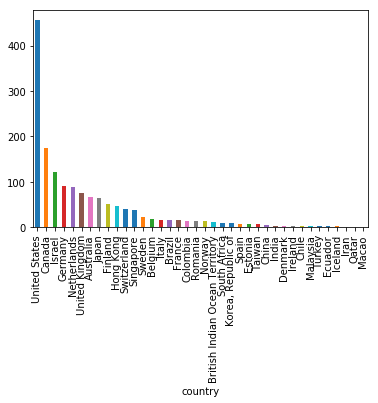

In [33]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?
That the number on the y axis is the number of countries the country on the x axis collaborates with: 

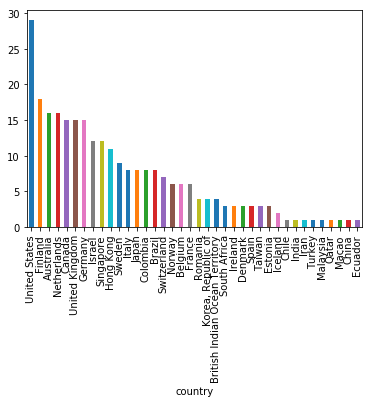

In [34]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
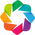

In [35]:
import holoviews as hv
hv.extension('bokeh')
%output size=200

In [36]:
n = hv.Dataset(nodes, 'index', 'country')

In [37]:
edges = pd.DataFrame(edges.groupby(['index_x']).index_y.value_counts())
edges.columns = ['counts']
edges.reset_index(inplace=True)

In [38]:
edges.sort_values(by='index_x', inplace=True)
edges.reset_index(drop=True, inplace=True)
edges = edges[~edges.apply(lambda x: str(sorted([x.index_x, x.index_y])), axis=1).duplicated()].reset_index(drop=True)

In [39]:
chord = hv.Chord((edges, n),['index_x', 'index_y'], ['counts'] )

In [40]:
%%opts Chord [edge_color_index='index_x' label_index='country' color_index='index'] 
%%opts Chord (cmap='Category20' edge_cmap='Category20')
chord

:Chord   [index_x,index_y]   (counts)

# Do the same for university:

In [41]:
pub_collab = associations[['file_x','name', 'country']].drop_duplicates()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()
collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

In [42]:
uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['index_x'] = collabs.name_x.map(uni_index)
collabs['index_y'] = collabs.name_y.map(uni_index)

edges = collabs[['index_x', 'index_y']]

In [43]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    i, j = int(row.index_x), int(row.index_y)
    adjacency[i, j] += 1
    
graph = nx.from_numpy_array(adjacency)
mapping = nodes.name.to_dict()

H=nx.relabel_nodes(graph,mapping)

nx.write_gexf(H, 'data/institution_graph.gexf')

number of different papers written in collaboration with an other university.

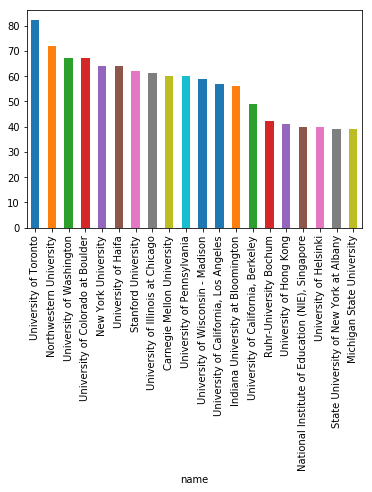

In [44]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

Number of distinct different institution collbaorations:
The number on the y axis is the number of different institutions a university collaborated with (without counting how often the did this.)

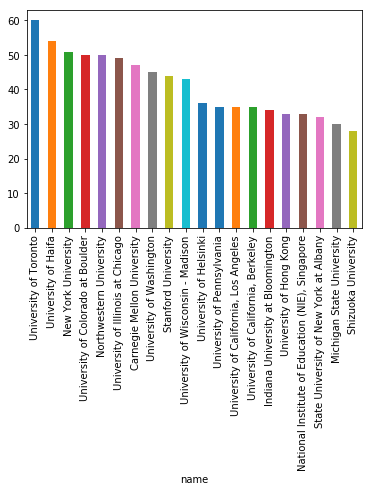

In [45]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

To make different visualisations possible we create a bin : others for universities that collaborate very little.

In [46]:
to_remove = nodes.loc[nodes.degrees < 25, 'name'].unique()

In [47]:
collabs.loc[(collabs.name_x.isin(to_remove)), 'name_x'] = 'Other'
collabs.loc[(collabs.name_y.isin(to_remove)), 'name_y'] = 'Other'
collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['index_x'] = collabs.name_x.map(uni_index)
collabs['index_y'] = collabs.name_y.map(uni_index)

edges = collabs[['index_x', 'index_y']].copy()

In [48]:
edges.sort_values(by='index_x', inplace=True)
edges.reset_index(drop=True, inplace=True)

In [49]:
edges = pd.DataFrame(edges.groupby(['index_x']).index_y.value_counts())
edges.columns = ['counts']
edges.reset_index(inplace=True)

In [50]:
edges = edges[~edges.apply(lambda x: str(sorted([x.index_x, x.index_y])), axis=1).duplicated()].reset_index(drop=True)

In [51]:
n = hv.Dataset(nodes, 'index', 'name')
chord = hv.Chord((edges, n),['index_x', 'index_y'], ['counts'] )

We can already observe from this graph that there seems to be a cluster of american universities that collaborate a lot with each other.

In [52]:
%%opts Chord [label_index='name' color_index='index' edge_color_index='index_x'] 
%%opts Chord (cmap='jet' edge_cmap='jet')
chord

:Chord   [index_x,index_y]   (counts)

# Looking at co authorship, taking into consideration country and inst.

In [53]:
associations.columns

Index(['name', 'domain', 'mail', 'authorindex', 'file_x', 'country',
       'merge_index', 'file_y', 'subject', 'iso', 'uri', 'type', 'publisher',
       'title', 'issued', 'accessioned', 'citation', 'available', 'abstract',
       'long_name', 'author_order', 'shortend_names', 'identifier'],
      dtype='object')

In [54]:
#we can drop one of the file columns
(associations.file_x != associations.file_y).sum()

0

In [55]:
associations['file'] = associations['file_x']
del associations['file_y'], associations['file_x']

In [56]:
associations = associations[associations.country.notna()]

In [57]:
self_merge = pd.merge(associations, associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = associations[~associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

In [87]:
edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)

n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    i, j = int(row.index_x), int(row.index_y)
    adjacency[i, j] += 1
    adjacency[j, i] = adjacency[i, j]
    
    
graph = nx.from_numpy_array(adjacency)

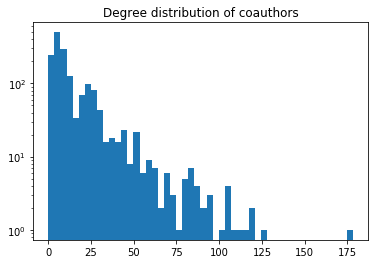

In [88]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

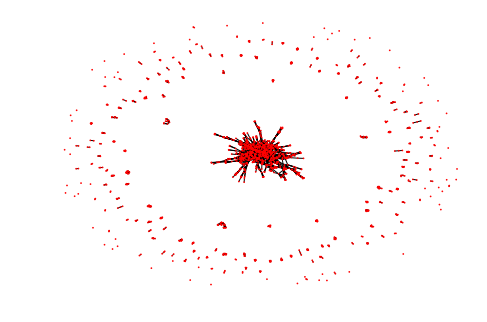

In [89]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=[0.5,0.5])

In [90]:
adjacency.shape

(1663, 1663)

We can easely find the people who worked with the most other people:
(counting repeat collaboration)

In [91]:
nodes['collabs_weighted'] = adjacency.sum(axis=1)
nodes.sort_values(by='collabs_weighted', ascending=False)[['long_name', 'country', 'name', 'collabs_weighted']].head(10)

,long_name,country,name,collabs_weighted
152,"Rummel, Nikol",Germany,Ruhr-University Bochum,178
85,"Zhang, Jianwei",United States,State University of New York at Albany,126
376,"Dillenbourg, Pierre",Switzerland,EPFL - EPF Lausanne,120
512,"Enyedy, Noel",United States,"University of California, Los Angeles",118
34,"Moher, Tom",United States,University of Illinois at Chicago,116
928,"kafai, yasmin",United States,University of Pennsylvania,112
35,"Slotta, James D.",Canada,University of Toronto,108
558,"Bang, Megan",United States,University of Washington,106
36,"Acosta, Alisa",Canada,University of Toronto,106
86,"Chen, Mei-Hwa",United States,State University of New York at Albany,104


Same as above but counting person only once:

In [92]:
nodes['collabs_unweighted'] = np.where(adjacency > 0, 1, 0).sum(axis=1)
nodes.sort_values(by='collabs_unweighted', ascending=False)[['long_name', 'country', 'name', 'collabs_unweighted']].head(10)

,long_name,country,name,collabs_unweighted
152,"Rummel, Nikol",Germany,Ruhr-University Bochum,59
558,"Bang, Megan",United States,University of Washington,48
36,"Acosta, Alisa",Canada,University of Toronto,46
85,"Zhang, Jianwei",United States,State University of New York at Albany,44
86,"Chen, Mei-Hwa",United States,State University of New York at Albany,41
829,"Kali, Yael",United States,Boston College,40
929,"Horn, Mike",United States,Northwestern University,39
512,"Enyedy, Noel",United States,"University of California, Los Angeles",38
34,"Moher, Tom",United States,University of Illinois at Chicago,36
376,"Dillenbourg, Pierre",Switzerland,EPFL - EPF Lausanne,36


In [93]:
print('Number of connected components : ', nx.number_connected_components(graph))

Number of connected components :  233


In [94]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

In [95]:
edge_dict = {}
for i, row in edges.iterrows():
    edge_dict[(row['index_x'], row['index_y'])] =  row['issued_x']

In [96]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
#nx.write_gexf(H, 'data/coauthor_graph.gexf')

In [97]:
#get components
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)

In [121]:
pos = nx.spring_layout(graph.subgraph(largest_cc))

In [119]:
I = graph.subgraph(largest_cc)

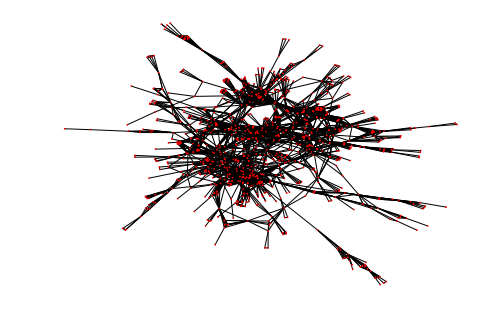

In [122]:
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5])

In [123]:
mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(I,mapping)

In [125]:
nx.write_gpickle(H, 'data/coauthor_graph')

People in largest connected component: 

In [72]:
main_component = nodes[nodes.index.isin(largest_cc)]

In [73]:
print("There are {} people in the largest component ".format(main_component.shape[0]))

There are 979 people in the largest component 


In [74]:
main_component.country.value_counts()

United States                     606
Germany                            72
Canada                             57
Israel                             32
Australia                          30
Singapore                          27
Finland                            21
Netherlands                        19
United Kingdom                     18
Japan                              18
Hong Kong                          16
Switzerland                        13
Sweden                              8
France                              6
Norway                              6
China                               5
Belgium                             5
Italy                               4
Taiwan                              4
Korea, Republic of                  2
Brazil                              2
Estonia                             1
Ecuador                             1
Colombia                            1
Denmark                             1
Chile                               1
Iceland     

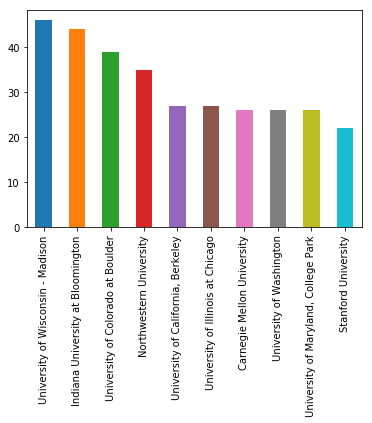

In [75]:
main_component.name.value_counts().head(10).plot(kind='bar')

## Modularity and more

Number of bridges (coonections for which removal creates more components) in the main component:
This indicates that they hold the component "together, they may 

In [ ]:
bridges = list(nx.bridges(graph))
bridges_1 = [y for x,y in bridges if x in largest_cc]
bridges_2 = [x for x,y in bridges if x in largest_cc]
len(set(bridges_1))

In [ ]:
names = main_component.long_name.to_dict()
pd.DataFrame([(names[j],names[bridges_2[i]]) for i,j in enumerate(bridges_1)], columns=['author_1', 'author_2']).head()

People that are bridges on both sides: - they are "bottle necks"

In [ ]:
#we can reduce this more by lookin at authors in both groups
len(set(bridges_2).intersection(set(bridges_1)))

In [ ]:
{names[s] for s in  set(bridges_2).intersection(set(bridges_1))}

Constructing the graph with the largest component:

In [ ]:
a = adjacency[list(largest_cc), :][:, list(largest_cc)]
graph = nx.from_numpy_array(a)

In [ ]:
# Cluster
sc = SpectralClustering(6, affinity='precomputed', n_init=100)
sc.fit(adjacency)

# Compare ground-truth and clustering-results
print('spectral clustering')
print(sc.labels_)
print('just for better-visualization: invert clusters (permutation)')
print(np.abs(sc.labels_ - 1))

In largest graph, maximum collaboration distance is 13 - we do not have a small world phenomenon with co-citation

In [ ]:
nx.diameter(graph)

In [ ]:
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(graph, pd.Series(sc.labels_).to_dict(), name='sc')
nx.set_node_attributes(graph, nx.degree_centrality(graph), name='centrality')

mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(graph,mapping)
nx.write_gexf(H, 'data/main_coauthor_graph.gexf')

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

We have to look at years as well to avoid duplicates, however, this could be due to people being associated to multiple institutions at once.

In [ ]:
name_country = associations[['name', 'mail', 'country', 'long_name', 'shortend_names','issued']]

In [ ]:
#Add year to see
df = pd.merge(name_country, name_country, on='long_name').dropna()
df = df[df.country_x != df.country_y]
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.country_x, x.country_y, x.issued_x, x.issued_y])), axis=1)
df[~df[['long_name', 'set_countries']].duplicated()].head()

In [ ]:
df = pd.merge(name_country, name_country, on='long_name').dropna()
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.name_x, x.name_y, x.issued_x, x.issued_y])), axis=1)
df = df[~df[['long_name', 'set_countries']].duplicated()]
df[(df.name_x != df.name_y) & (df.country_x != df.country_y)][['long_name','shortend_names_y', 'name_x', 'name_y', 'issued_x', 'issued_y']].head()

Number of people that changed organisation:

#TODO fix years

In [ ]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().head()

# Building for D3 graph 

In [ ]:
G = nx.to_pandas_edgelist(graph.subgraph(largest_cc))

G['author_source'] = G.source.map(nodes.long_name.to_dict())
G['author_target'] = G.target.map(nodes.long_name.to_dict())

G['uni_source'] = G.source.map(nodes.name.to_dict())
G['country_source'] = G.source.map(nodes.country.to_dict())

G['pos_source_x'] = G.source.map(lambda x: pos[x][0])
G['pos_source_y'] = G.source.map(lambda x: pos[x][1])
G['pos_target_x'] = G.target.map(lambda x: pos[x][0])
G['pos_target_y'] = G.target.map(lambda x: pos[x][1])

G.head()